# Lunch and learn: Machine learning with scikit-learn

## Goals of this notebook:
Demonstrate how to approach a machine learning problem with the tools of `scikit-learn`. Specifically, we will go through the typical process of tackling supervised learning problems:
    1. Define the problem
    2. Load and explore the data
    3. Prepare / clean the data for modeling
    4. Train the model
    5. Evaluate the model
    6. Tune / improve the model
    7. Use the model to predict the probability of outcomes
    
This notebook uses [bank marketing data](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing) from UCI Machine Learning repository. Data Source: S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems (2014), doi:10.1016/j.dss.2014.03.001.

## 1. Define the problem

The most important part of any ML problem is: **what puzzle(s) are we trying to solve?**

In this example, since we have data on bank marketing, some interesting questions might be:
- what indicators (x variables) have the biggest effect on whether a user will subscribe to a bank term deposit (y variable)?
- given that we have the variables required for the model for a given user, can we predict if the client will subscribe a bank term deposit (y variable)?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 50

## 2. Load and explore the data

In [3]:
df_raw = pd.read_csv('./data/bank-marketing-data/bank-additional-full.csv', sep=';')
df = pd.read_csv('./data/bank-marketing-data/bank-additional-full.csv', sep=';')

Based on the dataset's [README](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing), we know that the data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

Some notes about the dataset:
- Number of Instances: 41188 rows
- Number of Attributes: 20 + output attribute.
- Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 
- Not all attributes from the original dataset are included due to privacy concerns

### Input variables:
**bank client data:**   
1 - age (numeric)

2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

5 - default: has credit in default? (categorical: "no","yes","unknown")

6 - housing: has housing loan? (categorical: "no","yes","unknown")

7 - loan: has personal loan? (categorical: "no","yes","unknown")

**related with the last contact of the current campaign:**
   
8 - contact: contact communication type (categorical: "cellular","telephone") 

9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

**social and economic context attributes**

16 - emp.var.rate: employment variation rate -quarterly indicator (numeric)

17 - cons.price.idx: consumer price index -monthly indicator (numeric)     

18 - cons.conf.idx: consumer confidence index -monthly indicator (numeric)     

19 - euribor3m: euribor 3 month rate -daily indicator (numeric)

20 - nr.employed: number of employees -quarterly indicator (numeric)

### Output variable (target variable):

21 - y: has the client subscribed a term deposit? (binary: "yes","no")

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.describe()
# Note: .describe() only shows columns with numerical data. Columns containing strings are ommitted.

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# Baseline model
print(df['y'].value_counts())

no_count = float(df['y'].value_counts()['no'])
print(no_count/df.shape[0])

# A baseline model which always predicts 'no' will be correct 88.7% of the time. 
# Our model needs to be better than this!

no     36548
yes     4640
Name: y, dtype: int64
0.887345828882


## 3. Prepare / clean the data for modeling

### Treating missing values
We can treat missing values in 3 ways:
    - Impute (i.e. estimate) its value based on its other values
    - Drop the entire row
    - Use the label for missing values (in this case, "unknown") as a variable (i.e. do nothing)

In [130]:
# removing rows with "unknown" values
# for column in df.columns:
#     if (df[column].dtype == object): ## for columns that containing strings (dtype == object), remove rows with unknown
#         df = df[df[column] != 'unknown']

# Note: for this exercise, I've decided to retain to retain the rows containing "unknown" values because:
# 1) it would mean lose approx. 10,000 rows
# 2) models trained on dataset without missing values has 1% less accuracy as compared on models trained on the full dataset

### Preparing data for modelling

In [7]:
# Convert string data to numerical data so that scikitlearn can understand it
cols_to_transform = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
                    'poutcome', 'y']
df_with_dummies = pd.get_dummies(df, columns = cols_to_transform)

In [8]:
df_with_dummies.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,...,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [9]:
# Preparing the data into 2 sets: X and y variables

df_y = df_with_dummies[['y_yes']]
df_y.head()

,y_yes
0,0
1,0
2,0
3,0
4,0


In [10]:
del df_with_dummies['y_yes']
del df_with_dummies['y_no']
df_with_dummies.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [17]:
# convert pandas dataframe into numpy array
X = df_with_dummies.as_matrix()
y = df_y.as_matrix().ravel() # this step may not be necessary

## 4. Train the model

In [18]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [20]:
logisticregression = LogisticRegression().fit(X_train, y_train)
print("training set score: %f" % logisticregression.score(X_train, y_train))
print("test set score: %f" % logisticregression.score(X_test, y_test))

training set score: 0.908906
test set score: 0.912013


In [79]:
logisticregression_weighted = LogisticRegression().fit(X_train, y_train)
print("training set score: %f" % logisticregression_weighted.score(X_train, y_train))
print("test set score: %f" % logisticregression_weighted.score(X_test, y_test))

training set score: 0.907514
test set score: 0.913858


In [63]:
print("CONFUSION MATRIX")
confusion_matrix = metrics.confusion_matrix(expected, predicted)
print(confusion_matrix)

CONFUSION MATRIX
[[35613   935]
 [ 2785  1855]]


Confusion matrices (as shown above) are in the following format:
    
```
[[true_positive , false_negative]
 [false_positive, true_negative]]
```
In other words, if the business made marketing calls based entirely on our model, we would have:
    - Saved them 35613 wasted calls (and avoided bothering 35613 people unnecessarily!)
    - Accurately predict 1855 calls that converted into success
    - Caused 935 missed opportunities, which would have said yes if we had called (this is 20% of the number of clients (4640) who said 'yes' in this data set!)    
    - Wasted 2785 calls on false positives
    
Looks like this model is not ready for production until we can improve its accuracy further

In [64]:
expected = y
predicted = logisticregression.predict(X)
print("CLASSIFICATION REPORT")
classification_report = metrics.classification_report(expected, predicted)
print(classification_report)

CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.93      0.97      0.95     36548
          1       0.66      0.40      0.50      4640

avg / total       0.90      0.91      0.90     41188



Classification report shows 4 metrics: **precision, recall, f1-score, support1**

What is **precision, recall, f1-score, support1?**

**1. Precision** (also called positive predictive value) is the fraction of relevant instances among the retrieved instances

**2. Recall** (also known as sensitivity) is the fraction of relevant instances that have been retrieved over total relevant instances. 

Both precision and recall are therefore based on an understanding and measure of relevance.

![precision-recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

**3. F1 score** (also F-score or F-measure) is a measure of a test's accuracy in statistical analysis of binary classification. It considers both the precision p and the recall r of the test to compute the score: p is the number of correct positive results divided by the number of all positive results, and r is the number of correct positive results divided by the number of positive results that should have been returned. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.

![f1-score](https://wikimedia.org/api/rest_v1/media/math/render/svg/7d63c1f5c659f95b5dfe5893213cc8ea7f8bea0a)

**4. Support** is the number of occurrences of each class in y_true.

In [50]:
# Tuning the logistic regression model
C=[0.01, 0.1, 1, 10, 100]

for c in C:
    print("training set score: %f" % LogisticRegression(C=c).fit(X_train, y_train).score(X_train, y_train))
    print("test set score: %f" % LogisticRegression(C=c).fit(X_train, y_train).score(X_test, y_test))

training set score: 0.909974
test set score: 0.911528
training set score: 0.908938
test set score: 0.912013
training set score: 0.908906
test set score: 0.912013
training set score: 0.908906
test set score: 0.912013
training set score: 0.908906
test set score: 0.912013


In [ ]:
# demonstrating the difference between C parameter

In [30]:
logisticregression_001 = LogisticRegression(C=0.01).fit(X_train, y_train)
logisticregression_1 = LogisticRegression(C=1).fit(X_train, y_train)
logisticregression_10 = LogisticRegression(C=10).fit(X_train, y_train)

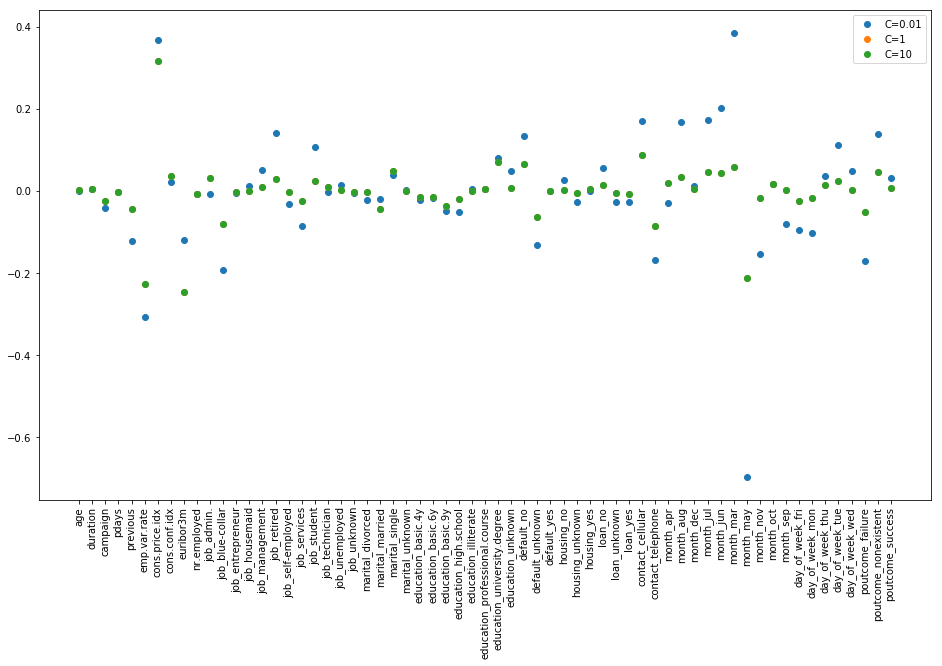

In [31]:
plt.figure(figsize=(16,9))

plt.plot(logisticregression_001.coef_.T, 'o', label="C=0.01")
plt.plot(logisticregression_1.coef_.T, 'o', label="C=1")
plt.plot(logisticregression_10.coef_.T, 'o', label="C=10")
plt.xticks(range(X.shape[1]), df_with_dummies.columns, rotation=90)
plt.legend()

## 5. Evaluate the model

In [25]:
from sklearn import metrics

In [28]:
expected = y
predicted = logisticregression.predict(X)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95     36548
          1       0.66      0.40      0.50      4640

avg / total       0.90      0.91      0.90     41188



In [29]:
print(metrics.confusion_matrix(expected, predicted))

[[35613   935]
 [ 2785  1855]]


In [32]:
# Accuracy score of our model
print(metrics.accuracy_score(expected, predicted))

0.909682431776


## 6. Tune / improve the model

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
# The params which we can tune to improve our model
# These are passed into LogisticRegression() when we instantiate our model

logisticregression.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [82]:
logisticregression_tuned = LogisticRegression()

param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'class_weight': [{
                  0: 1, 
                  1: 2
              },
              {
                  0: 1, 
                  1: 1.2
              },
              {
                  0: 1, 
                  1: 1.4
              },
              {
                  0: 1, 
                  1: 1.6
              },
              {
                  0: 1, 
                  1: 2
              }
              ]}

# using the default scoring of accuracy:
grid = GridSearchCV(estimator=logisticregression_tuned, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best estimator:", grid.best_estimator_)
print("Best score:", grid.best_score_)
print(pd.DataFrame(grid.cv_results_))

('Best estimator:', LogisticRegression(C=0.01, class_weight={0: 1, 1: 1.2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))
('Best score:', 0.91003852254702011)
    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0        0.182260         0.000632         0.907708          0.908177    0.01   
1        0.190172         0.000690         0.910039          0.910435    0.01   
2        0.184792         0.000619         0.909100          0.909941    0.01   
3        0.192418         0.000693         0.909715          0.909699    0.01   
4        0.173774         0.000596         0.907708          0.908177    0.01   
5        0.192760         0.000666         0.907060          0.908582     0.1   
6        0.174264         0.000608         0.909974          0.910395     0.1   
7        0.213790 

In [83]:
expected_2 = y
predicted_2 = grid.predict(X)
# summarize the fit of the model
print(metrics.confusion_matrix(expected_2, predicted_2))

[[35409  1139]
 [ 2521  2119]]


## Using our model to see the size of the impact of each attribute on the outcome

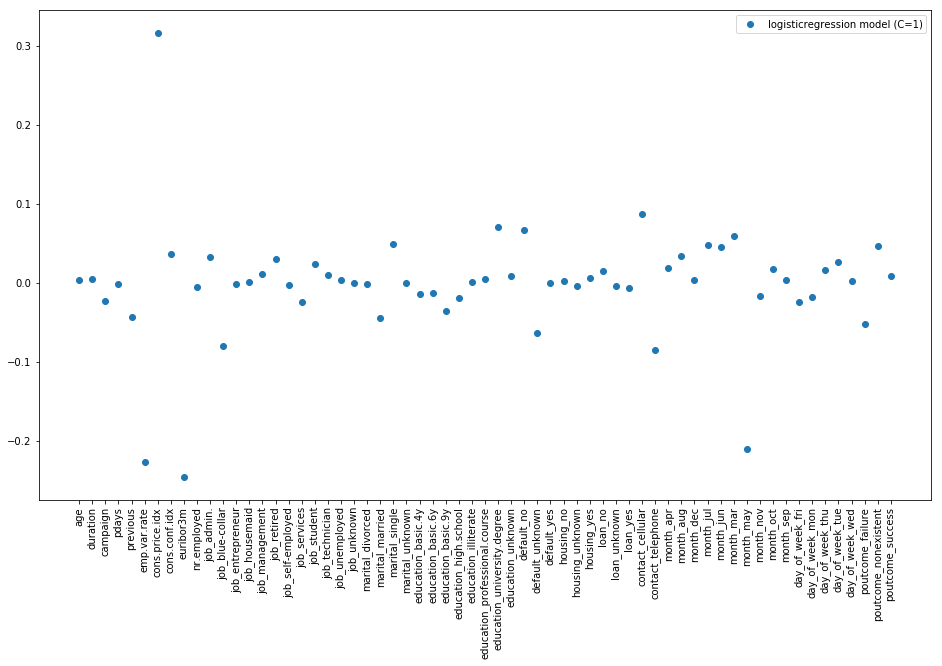

In [49]:
plt.figure(figsize=(16,9))

plt.plot(logisticregression.coef_.T, 'o', label="logisticregression model (C=1)")
plt.xticks(range(X.shape[1]), df_with_dummies.columns, rotation=90)
plt.legend()

Based on this chart, we can see observe the following: 
    
Attributes that have a positive effect on the outcome:
- consumer price index
- education (university degree)
- default_no
- contact_cellular

Attributes that have a negative effect on the outcome:
- emp.var.rate
- euribor3m
- job_blue_collar
- contact_telephone
- month_may

In [ ]:
TODO: Add notes on how to interpret the data
Add section on key findings / actionables

## 7. Using the model to predict outcomes based on fresh/unseen data

In [40]:
# Using our trained model to predict whether y will be 1 or 0

sample_input = X_test[0]

# Using .predict_proba() .predict_proba() returns the probability of the sample for each class in the model, where classes are ordered as 
# they are in self.classes_.
print(logisticregression.predict_proba(sample_input))


# Using .predict()  This returns the class label (i.e. whether the prediction is 0 or 1)
print(logisticregression.predict(sample_input))

[[ 0.90609139  0.09390861]]
[0]


/Users/davidtan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/davidtan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [ ]:
## Bonus: Trying different models:

## Random forest classifier (+ optimization with GridSearch)

In [45]:
rfc_raw = RandomForestClassifier(max_depth=5, 
                                 min_samples_leaf=10, 
                                 max_features=10, 
                                 bootstrap=False)
rfc_raw.fit(X_train, y_train)

print("training set score: %f" % rfc_raw.score(X_train, y_train))
print("test set score: %f" % rfc_raw.score(X_test, y_test))

training set score: 0.908582
test set score: 0.904438


In [84]:
expected_3 = y
predicted_3 = rfc_raw.predict(X)
# summarize the fit of the model
print(metrics.confusion_matrix(expected_3, predicted_3))

[[36216   332]
 [ 3476  1164]]


In [89]:
# NOTE: This will take about 1-2 minutes to run!
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rfc_model = RandomForestClassifier()
grid_2 = GridSearchCV(estimator=rfc_model, param_grid=param_grid, cv=5)

grid_2.fit(X_train, y_train)

print("Best estimator:", grid_2.best_estimator_)
print("Best score:", grid_2.best_score_)
print(pd.DataFrame(grid_2.cv_results_))

('Best estimator:', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))
('Best score:', 0.9124340422776861)
     mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0         0.064834         0.010079         0.887281          0.887281   
1         0.056524         0.008793         0.887281          0.887281   
2         0.057247         0.007942         0.887281          0.887281   
3         0.055738         0.007831         0.887281          0.887281   
4         0.056371         0.008640         0.887281          0.887281   
5         0.060825         0.009170         0.887281          0.887281   
6         0.059547         0.008254        

In [90]:
expected_4 = y
predicted_4 = grid_2.predict(X)
# summarize the fit of the model
print(metrics.confusion_matrix(expected_4, predicted_4))

[[35904   644]
 [ 2001  2639]]


### KNN model

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

knn_model = knn_model.fit(X_train, y_train)

print("training set score: %f" % knn_model.score(X_train, y_train))
print("test set score: %f" % knn_model.score(X_test, y_test))

training set score: 0.930789
test set score: 0.908420


In [86]:
expected_5 = y
predicted_5 = knn_model.predict(X)
# summarize the fit of the model
print(metrics.confusion_matrix(expected_5, predicted_5))

[[35442  1106]
 [ 1975  2665]]


### Decision tree model

In [47]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier().fit(X_train, y_train)

print("training set score: %f" % decision_tree_model.score(X_train, y_train))
print("test set score: %f" % decision_tree_model.score(X_test, y_test))

training set score: 1.000000
test set score: 0.895115


In [87]:
expected_6 = y
predicted_6 = decision_tree_model.predict(X)
# summarize the fit of the model
print(metrics.confusion_matrix(expected_6, predicted_6))

[[36012   536]
 [  544  4096]]


### Support vector machines (SVM)

In [48]:
from sklearn.svm import SVC
svc_model = SVC().fit(X_train, y_train)

print("training set score: %f" % svc_model.score(X_train, y_train))
print("test set score: %f" % svc_model.score(X_test, y_test))

training set score: 0.959470
test set score: 0.897931


In [88]:
expected_7 = y
predicted_7 = svc_model.predict(X)
# summarize the fit of the model
print(metrics.confusion_matrix(expected_7, predicted_7))

[[36215   333]
 [ 1970  2670]]


## Picking the best model

Having tried out several different models, let's pick the best model (RandomForestClassifiers with ...params) can compare its classification report with our first logistic regression model

Refresher: Confusion matrices (as shown above) are in the following format:
```
[[true_positive , false_negative]
 [false_positive, true_negative]]
```

In [91]:
expected_3 = y
predicted_3 = rfc_raw.predict(X)
# summarize the fit of the model
print(metrics.confusion_matrix(expected_3, predicted_3))

[[36216   332]
 [ 3476  1164]]


In other words, if the business made marketing calls based entirely on our model, we would have:
    - Saved them 36216 (up from 35613) wasted calls
    - Accurately predict 1164 (down from 1855) calls that converted into success
    - Caused 332 (down from 935!) missed opportunities, which would have said yes if we had called (this is approx. 7% of the number of clients (4640) who said 'yes' in this data set!)    
    - Wasted 3476 (up from 2785) calls on false positives

# Conclusion / key findings / business recommendations: